# Анализ данных аминокислотных последовательностей с OAS (Observed Antibody Space database) и использование предложенного алгоритма

Загрузили данные с OAS с помощью скрипта с сайта:

In [5]:
! chmod +x bulk_download.sh

In [ ]:
! ./bulk_download.sh

--2025-11-22 12:11:09--  https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Eccles_2020/csv/SRR10358523_paired.csv.gz
Resolving proxy (proxy)... 10.64.2.122
Connecting to proxy (proxy)|10.64.2.122|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 105743 (103K) [application/x-gzip]
Saving to: ‘SRR10358523_paired.csv.gz’

SRR10358523_paired. 100%[===================>] 103.26K  --.-KB/s    in 0.1s    

2025-11-22 12:11:09 (985 KB/s) - ‘SRR10358523_paired.csv.gz’ saved [105743/105743]

--2025-11-22 12:11:09--  https://opig.stats.ox.ac.uk/webapps/ngsdb/paired/Eccles_2020/csv/SRR10358524_paired.csv.gz
Resolving proxy (proxy)... 10.64.2.122
Connecting to proxy (proxy)|10.64.2.122|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 57326 (56K) [application/x-gzip]
Saving to: ‘SRR10358524_paired.csv.gz’

SRR10358524_paired. 100%[===================>]  55.98K  --.-KB/s    in 0.06s   

2025-11-22 12:11:09 (976 KB/s) - ‘SRR10358524_paired.csv.gz’ sav

In [7]:
ls

bulk_download.sh*  oas_filtered/  oas_raw/  Untitled.ipynb


Для каждой загруженной таблицы выделяем интересующие нас столбцы с cdr1, cdr2, отбираем только IGHV3-21

In [12]:
import os
import pandas as pd

INPUT_DIR = "oas_raw"
OUTPUT_DIR = "oas_filtered_IGHV3-21"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Какие столбцы мы хотим
target_cols = [
    "sequence_id_heavy",
    "v_call_heavy",
    "sequence_alignment_heavy",
    "sequence_alignment_aa_heavy",
    "cdr1_heavy",
    "cdr1_aa_heavy",
    "cdr2_heavy",
    "cdr2_aa_heavy"
]

for file in os.listdir(INPUT_DIR):
    if not file.endswith(".csv"):
        continue

    path = os.path.join(INPUT_DIR, file)
    print(f"Processing {path}")

    try:
        # Пропускаем первую строку (header=0 -> вторая строка)
        df = pd.read_csv(path, skiprows=1, header=0, dtype=str)

        # Если нет нужных колонок — пропускаем
        if "v_call_heavy" not in df.columns:
            print("  → пропущен: нет v_call_heavy")
            continue

        # Фильтруем по IGHV3-21
        df = df[df["v_call_heavy"].astype(str).str.startswith("IGHV3-21")]

        if df.empty:
            print("  → пропущен: нет IGHV3-21")
            continue

        # Оставляем только существующие среди нужных
        cols_exist = [c for c in target_cols if c in df.columns]
        df = df[cols_exist]

        # Сохраняем
        out_path = os.path.join(
            OUTPUT_DIR,
            file.replace(".csv", "_IGHV3-21.csv")
        )
        df.to_csv(out_path, index=False)
        print(f"  → сохранено в {out_path}")

    except Exception as e:
        print(f"Ошибка в {file}: {e}")


Processing oas_raw/GSM6504716_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/GSM6504716_1_Paired_All_IGHV3-21.csv
Processing oas_raw/GSM6504763_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/GSM6504763_1_Paired_All_IGHV3-21.csv
Processing oas_raw/GSM6504709_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/GSM6504709_1_Paired_All_IGHV3-21.csv
Processing oas_raw/1287149_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/1287149_1_Paired_All_IGHV3-21.csv
Processing oas_raw/1287144_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/1287144_1_Paired_All_IGHV3-21.csv
Processing oas_raw/GSM6504749_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/GSM6504749_1_Paired_All_IGHV3-21.csv
Processing oas_raw/1279074_1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/1279074_1_Paired_All_IGHV3-21.csv
Processing oas_raw/AT6md_S1__1_Paired_All.csv
  → сохранено в oas_filtered_IGHV3-21/AT6md_S1__1_Paired_All_IGHV3-21.csv
Processing oas_raw/GSM7286903_1_Paired_All.c

Создаём лого с самыми популярными последовательностями аминокислот и нуклеотидов:

In [26]:
import pandas as pd
import os
import logomaker
import matplotlib.pyplot as plt

INPUT_DIR = "oas_filtered_IGHV3-21"

cdr1_seqs = []
cdr2_seqs = []

# Собираем все последовательности
for fname in os.listdir(INPUT_DIR):
    if not fname.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(INPUT_DIR, fname), dtype=str)
    if 'cdr1_aa_heavy' in df.columns:
        cdr1_seqs.extend(df['cdr1_aa_heavy'].dropna().tolist())
    if 'cdr2_aa_heavy' in df.columns:
        cdr2_seqs.extend(df['cdr2_aa_heavy'].dropna().tolist())

print(f"CDR1: {len(cdr1_seqs)} sequences, CDR2: {len(cdr2_seqs)} sequences")

# Фильтруем только последовательности длиной 8
cdr1_seqs_8 = [s for s in cdr1_seqs if len(s) == 8]
cdr2_seqs_8 = [s for s in cdr2_seqs if len(s) == 8]

print(f"CDR1 length 8: {len(cdr1_seqs_8)} sequences, CDR2 length 8: {len(cdr2_seqs_8)} sequences")

# Функция построения логотипа
def make_logo(sequences, title, output_file):
    counts_df = logomaker.alignment_to_matrix(sequences, to_type='counts')
    pwm_df = counts_df.div(counts_df.sum(axis=1), axis=0)
    
    plt.figure(figsize=(max(8, len(pwm_df)/2), 3))
    logo = logomaker.Logo(pwm_df, shade_below=.5, fade_below=.5)
    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show
    plt.close()
    print(f"Saved logo to {output_file}")

# Создаём лого только для последовательностей длиной 8
make_logo(cdr1_seqs_8, "IGHV3-21 CDR1 Logo (length 8)", "CDR1_logo_8.png")
make_logo(cdr2_seqs_8, "IGHV3-21 CDR2 Logo (length 8)", "CDR2_logo_8.png")


CDR1: 37695 sequences, CDR2: 37717 sequences
CDR1 length 8: 37612 sequences, CDR2 length 8: 36783 sequences
Saved logo to CDR1_logo_8.png
Saved logo to CDR2_logo_8.png


<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

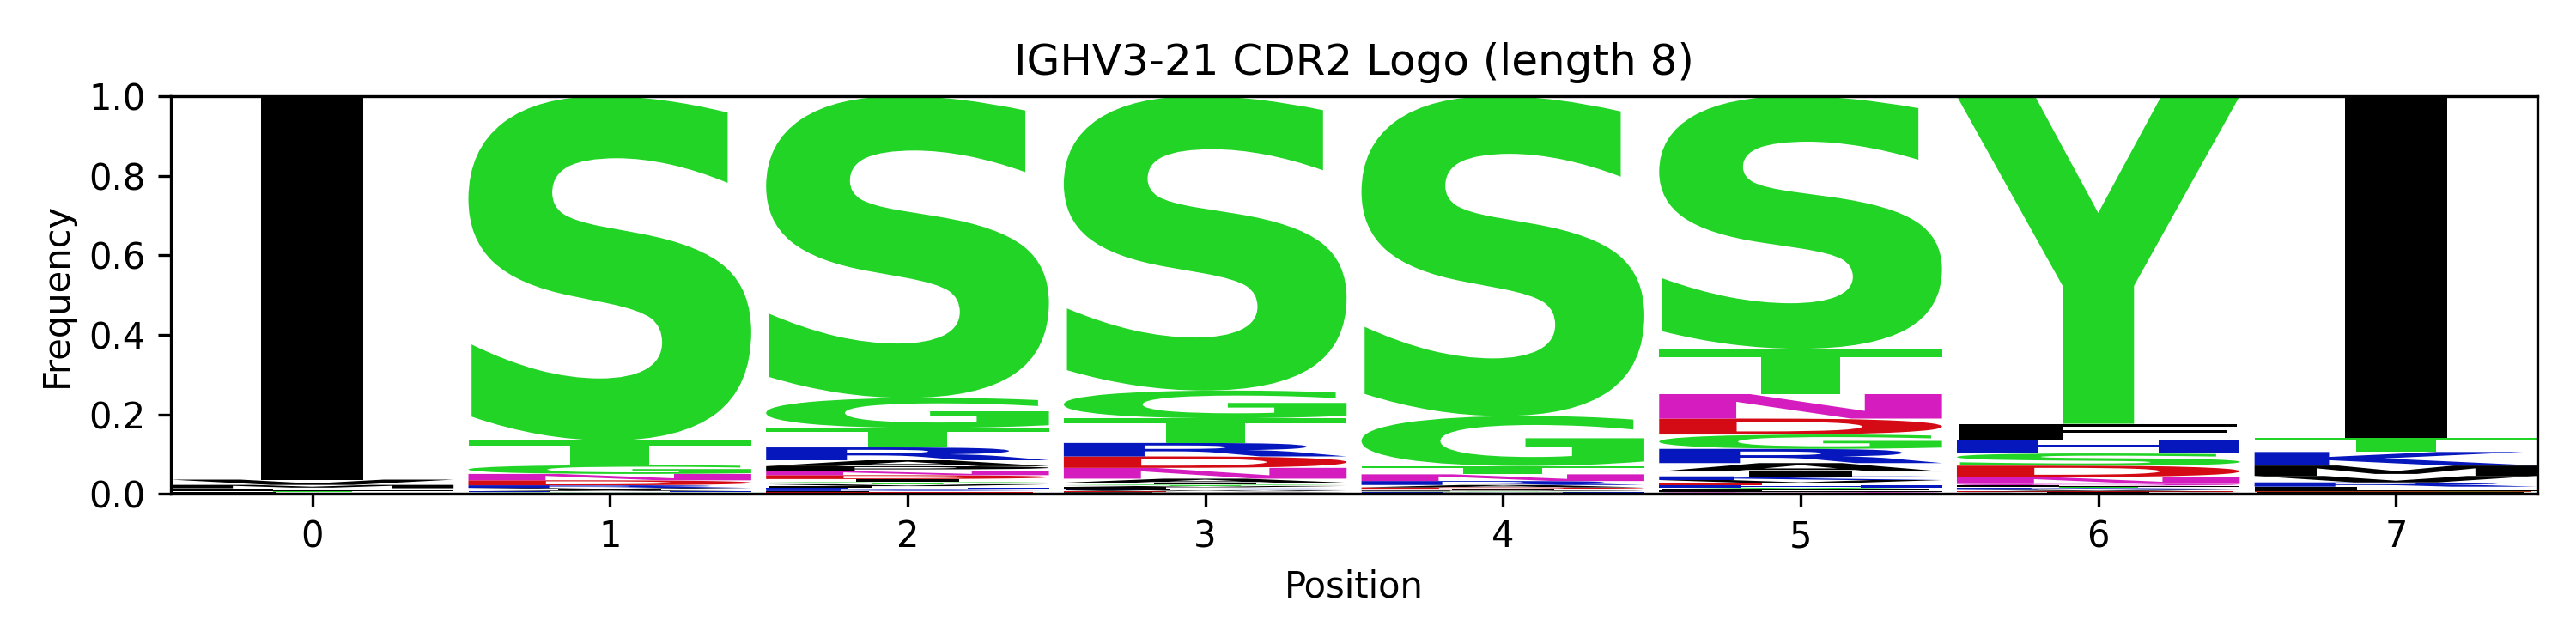

In [27]:
from IPython.display import Image

# Показываем картинку
Image(filename="CDR2_logo_8.png")

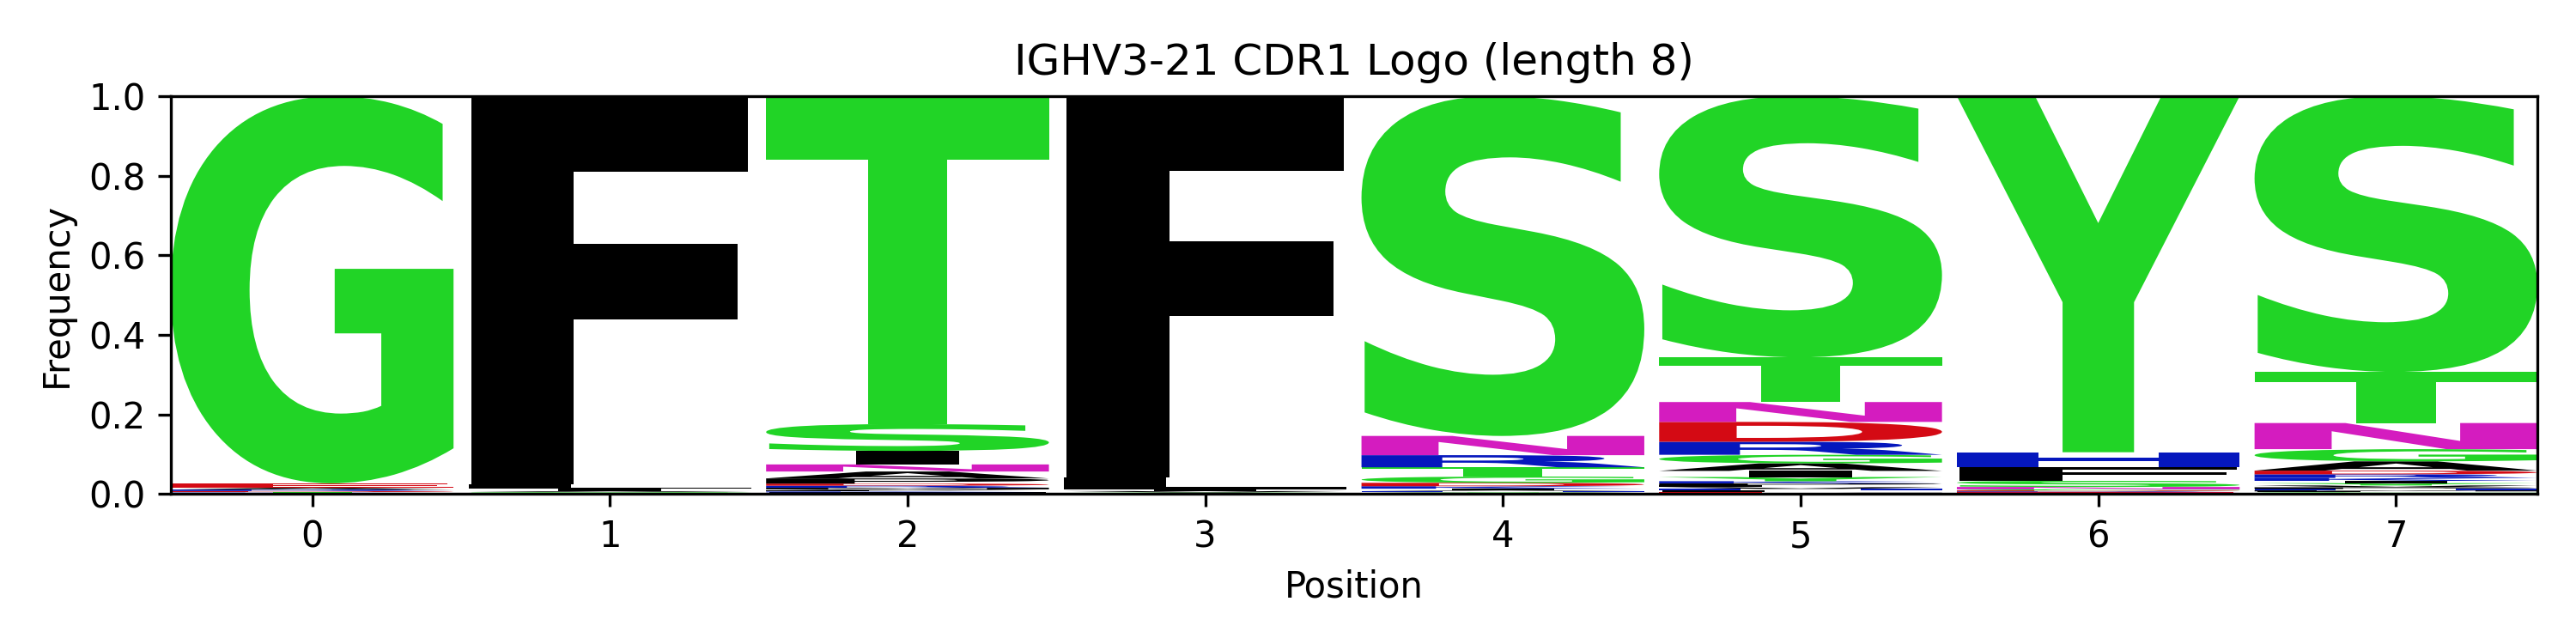

In [28]:
from IPython.display import Image

# Показываем картинку
Image(filename="CDR1_logo_8.png")

In [19]:
lengths = [len(s) for s in cdr1_seqs]

from collections import Counter
length_counts = Counter(lengths)
print("Распределение длин:", length_counts)

Распределение длин: Counter({8: 37612, 11: 13, 10: 12, 6: 11, 9: 9, 15: 9, 7: 7, 5: 7, 12: 6, 1: 3, 13: 3, 4: 2, 2: 1})


In [21]:
lengths = [len(s) for s in cdr2_seqs]

length_counts = Counter(lengths)
print("Распределение длин:", length_counts)

Распределение длин: Counter({8: 36783, 7: 553, 9: 134, 6: 86, 10: 59, 11: 42, 12: 16, 5: 15, 14: 7, 16: 6, 13: 5, 4: 4, 15: 3, 2: 2, 18: 1, 1: 1})


Объединённая таблица:

In [22]:
import os
import pandas as pd

INPUT_DIR = "oas_filtered_IGHV3-21"
OUTPUT_FILE = "IGHV3-21_all.csv"

all_dfs = []

for fname in os.listdir(INPUT_DIR):
    if not fname.endswith(".csv"):
        continue
    path = os.path.join(INPUT_DIR, fname)
    df = pd.read_csv(path, dtype=str)
    all_dfs.append(df)

# Объединяем все DataFrame в один
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Saved combined CSV with {len(combined_df)} rows to {OUTPUT_FILE}")
else:
    print("Нет CSV файлов для объединения.")


Saved combined CSV with 37726 rows to IGHV3-21_all.csv


In [23]:
import pandas as pd

# Входной объединённый CSV
INPUT_FILE = "IGHV3-21_all.csv"

# Читаем CSV
df = pd.read_csv(INPUT_FILE, dtype=str)

# Функция для подсчёта уникальных последовательностей
def count_unique_sequences(df, column_name):
    if column_name not in df.columns:
        print(f"Колонки {column_name} нет в файле")
        return None
    counts = df[column_name].dropna().value_counts()
    # Превращаем в DataFrame
    counts_df = counts.reset_index()
    counts_df.columns = [column_name, "count"]
    return counts_df

# CDR1
cdr1_counts = count_unique_sequences(df, "cdr1_aa_heavy")
cdr1_counts.to_csv("CDR1_unique_counts.csv", index=False)
print(f"CDR1: {len(cdr1_counts)} уникальных последовательностей сохранено в CDR1_unique_counts.csv")

# CDR2
cdr2_counts = count_unique_sequences(df, "cdr2_aa_heavy")
cdr2_counts.to_csv("CDR2_unique_counts.csv", index=False)
print(f"CDR2: {len(cdr2_counts)} уникальных последовательностей сохранено в CDR2_unique_counts.csv")


CDR1: 4472 уникальных последовательностей сохранено в CDR1_unique_counts.csv
CDR2: 7816 уникальных последовательностей сохранено в CDR2_unique_counts.csv


In [32]:
df = pd.read_csv('CDR1_unique_counts.csv')
df

,cdr1_aa_heavy,count
0,GFTFSSYS,18027
1,GFTFSTYS,981
2,GFTFSSYT,894
3,GFTFSSYN,363
4,GFTFSTYT,321
...,...,...
4467,RFTFRNYD,1
4468,GFRFRNYG,1
4469,GFKFSSFS,1
4470,GFSFNNHD,1


In [33]:
df = pd.read_csv('CDR2_unique_counts.csv')
df

,cdr2_aa_heavy,count
0,ISSSSSYI,16789
1,ISSSSTYI,564
2,ISSSSNYI,295
3,ISSGSSYI,208
4,ISSSGSYI,208
...,...,...
7811,VSSRSTST,1
7812,ISGNNKYI,1
7813,IIARNGYT,1
7814,INTNSDYI,1


In [35]:
import pandas as pd
import os
import logomaker
import matplotlib.pyplot as plt

INPUT_DIR = "oas_filtered_IGHV3-21"

cdr1_seqs = []
cdr2_seqs = []

# Собираем все нуклеотидные последовательности
for fname in os.listdir(INPUT_DIR):
    if not fname.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(INPUT_DIR, fname), dtype=str)
    if 'cdr1_heavy' in df.columns:
        cdr1_seqs.extend(df['cdr1_heavy'].dropna().tolist())
    if 'cdr2_heavy' in df.columns:
        cdr2_seqs.extend(df['cdr2_heavy'].dropna().tolist())

print(f"CDR1: {len(cdr1_seqs)} sequences, CDR2: {len(cdr2_seqs)} sequences")

# Фильтруем только последовательности длиной 8 нуклеотидов
cdr1_seqs_8 = [s for s in cdr1_seqs if len(s) == 24]
cdr2_seqs_8 = [s for s in cdr2_seqs if len(s) == 24]

print(f"CDR1 length 8: {len(cdr1_seqs_8)} sequences, CDR2 length 8: {len(cdr2_seqs_8)} sequences")

# Функция построения логотипа
def make_logo(sequences, title, output_file):
    counts_df = logomaker.alignment_to_matrix(sequences, to_type='counts')
    pwm_df = counts_df.div(counts_df.sum(axis=1), axis=0)
    
    plt.figure(figsize=(max(8, len(pwm_df)/2), 3))
    logo = logomaker.Logo(pwm_df, shade_below=.5, fade_below=.5)
    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved logo to {output_file}")

# Создаём логотипы для нуклеотидных последовательностей длиной 8
make_logo(cdr1_seqs_8, "IGHV3-21 CDR1 Nucleotide Logo", "CDR1_nt_logo_8.png")
make_logo(cdr2_seqs_8, "IGHV3-21 CDR2 Nucleotide Logo", "CDR2_nt_logo_8.png")


CDR1: 37698 sequences, CDR2: 37718 sequences
CDR1 length 8: 37612 sequences, CDR2 length 8: 36780 sequences
Saved logo to CDR1_nt_logo_8.png
Saved logo to CDR2_nt_logo_8.png


<Figure size 1200x300 with 0 Axes>

<Figure size 1200x300 with 0 Axes>

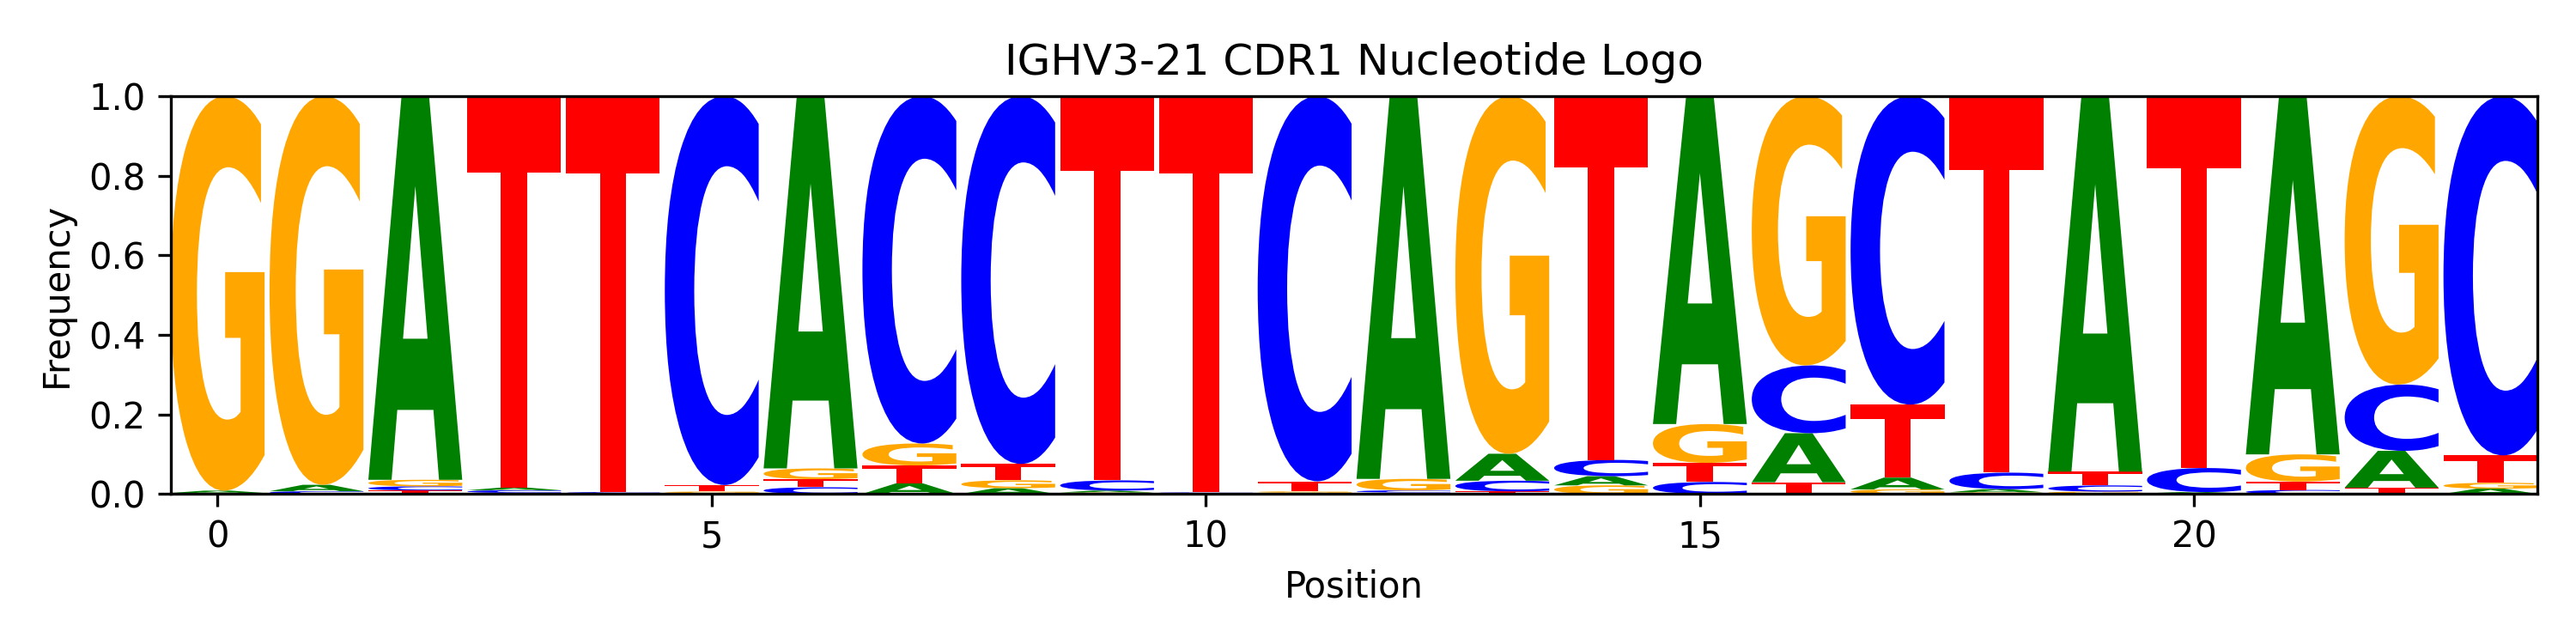

In [36]:
from IPython.display import Image

# Показываем картинку
Image(filename="CDR1_nt_logo_8.png")

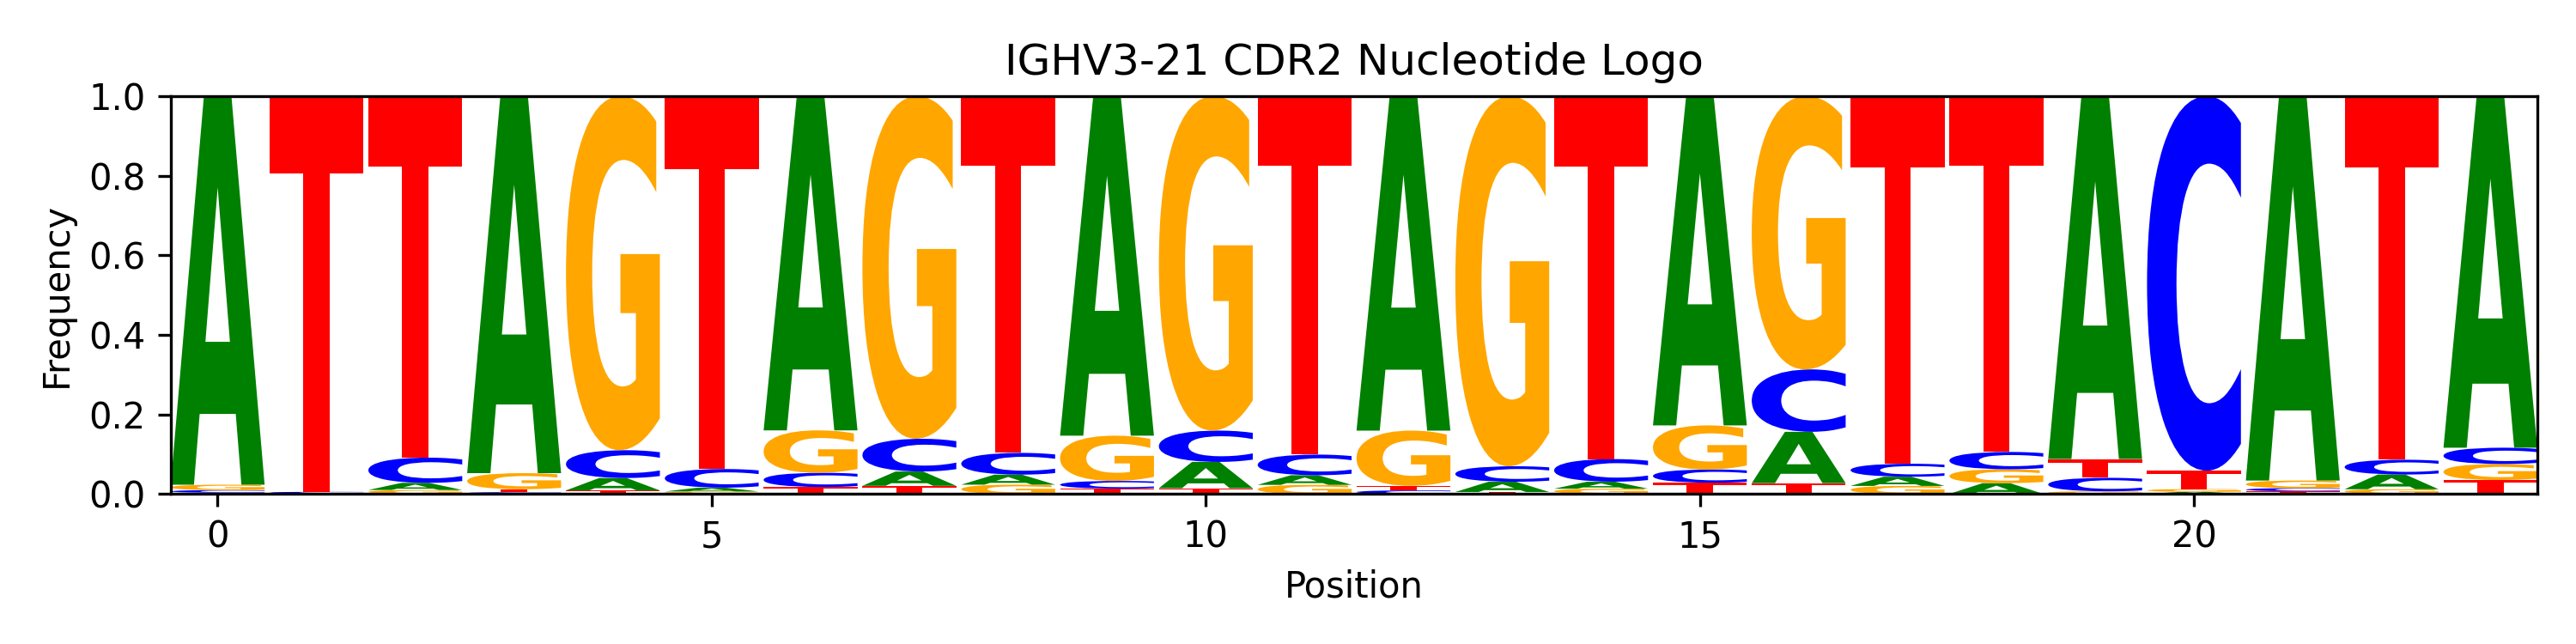

In [37]:
from IPython.display import Image

# Показываем картинку
Image(filename="CDR2_nt_logo_8.png")

In [26]:
import pandas as pd
from collections import Counter

def analyze_cdr(csv_file, column_name, target_length=8):
    # Читаем CSV
    df = pd.read_csv(csv_file, dtype=str)
    df['count'] = df['count'].astype(int)
    
    # Отсекаем последовательности, которые встречаются 1 раз
    df = df[df['count'] > 1]
    
    # Оставляем только последовательности длиной target_length
    df = df[df[column_name].str.len() == target_length]
    
    print(f"After filtering, {len(df)} sequences of length {target_length} remain")
    
    # Подсчёт аминокислот по позициям
    position_counts = [Counter() for _ in range(target_length)]
    
    for seq, cnt in zip(df[column_name], df['count']):
        for i, aa in enumerate(seq):
            position_counts[i][aa] += cnt
    
    # Выводим результат
    for i, counter in enumerate(position_counts):
        total = sum(counter.values())
        if total == 0:
            continue
        print(f"\nPosition {i+1}:")
        for aa, c in counter.most_common():
            percent = c / total * 100
            print(f"{aa} ({c}, {percent:.1f}%)", end=", ")
        print()  # новая строка после позиции

# Пример использования для CDR1
print("CDR1 analysis:")
analyze_cdr("CDR1_unique_counts.csv", "cdr1_aa_heavy", target_length=8)

# Пример использования для CDR2
print("\nCDR2 analysis:")
analyze_cdr("CDR2_unique_counts.csv", "cdr2_aa_heavy", target_length=8)


CDR1 analysis:
After filtering, 1709 sequences of length 8 remain

Position 1:
G (34296, 98.2%), E (291, 0.8%), A (124, 0.4%), R (82, 0.2%), D (45, 0.1%), K (25, 0.1%), T (25, 0.1%), Q (15, 0.0%), S (9, 0.0%), V (2, 0.0%), N (2, 0.0%), 

Position 2:
F (34425, 98.6%), L (232, 0.7%), I (131, 0.4%), V (43, 0.1%), S (39, 0.1%), Y (36, 0.1%), H (4, 0.0%), M (2, 0.0%), N (2, 0.0%), W (2, 0.0%), 

Position 3:
T (29884, 85.6%), S (2076, 5.9%), I (1073, 3.1%), A (476, 1.4%), N (427, 1.2%), P (355, 1.0%), D (131, 0.4%), R (123, 0.4%), M (108, 0.3%), V (74, 0.2%), L (64, 0.2%), K (48, 0.1%), F (38, 0.1%), G (18, 0.1%), E (10, 0.0%), Q (6, 0.0%), Y (3, 0.0%), H (2, 0.0%), 

Position 4:
F (33884, 97.0%), L (797, 2.3%), I (82, 0.2%), V (69, 0.2%), Y (54, 0.2%), S (27, 0.1%), A (3, 0.0%), 

Position 5:
S (30858, 88.4%), N (1445, 4.1%), R (900, 2.6%), T (664, 1.9%), G (425, 1.2%), D (211, 0.6%), K (159, 0.5%), I (84, 0.2%), H (37, 0.1%), V (33, 0.1%), A (29, 0.1%), E (24, 0.1%), Y (21, 0.1%), M (8, 0.

Основываясь на статистике встречаемости различных аминокислот выбирали порог % по встречаемости и на этом строили варианты для генерации:

Первым вариантом взяли порог в 5%:

In [5]:
cdr1 = {
    "pos_1": ["G"],
    "pos_2": ["F"],
    "pos_3": ["T", "S"],
    "pos_4": ["F"],
    "pos_5": ["S"],
    "pos_6": ["S", "T"],
    "pos_7": ["Y"],
    "pos_8": ["S", "T", "N"]
}

cdr2 = {
    "pos_1": ["I"],
    "pos_2": ["S"],
    "pos_3": ["S", "G"],
    "pos_4": ["S", "G", "T"],
    "pos_5": ["S", "G"],
    "pos_6": ["S", "T", "N"],
    "pos_7": ["Y"],
    "pos_8": ["I"]
}


In [6]:
import itertools
import pandas as pd


# Генерация всех последовательностей
def generate_sequences(cdr_dict):
    positions = [cdr_dict[f"pos_{i+1}"] for i in range(len(cdr_dict))]
    all_combinations = itertools.product(*positions)
    sequences = [''.join(seq) for seq in all_combinations]
    return sequences

cdr1_seqs = generate_sequences(cdr1)
cdr2_seqs = generate_sequences(cdr2)

print(f"Number of CDR1 sequences: {len(cdr1_seqs)}")
print(f"Number of CDR2 sequences: {len(cdr2_seqs)}")

# Генерация всех комбинаций CDR1 + CDR2
all_combinations = itertools.product(cdr1_seqs, cdr2_seqs)

# Сохраняем в DataFrame (можно использовать iterator, если комбинаций очень много)
df = pd.DataFrame(all_combinations, columns=["CDR1", "CDR2"])

print(f"Total combinations: {len(df)}")
# Сохраняем в CSV
df.to_csv("cdr1_cdr2_combinations.csv", index=False)
print("Saved to cdr1_cdr2_combinations.csv")

Number of CDR1 sequences: 12
Number of CDR2 sequences: 36
Total combinations: 432
Saved to cdr1_cdr2_combinations.csv


In [4]:
import pandas as pd

# Читаем объединённый CSV
df = pd.read_csv("IGHV3-21_all.csv", dtype=str)

# Отбираем только нужные столбцы и убираем пропуски
df = df[['cdr1_aa_heavy', 'cdr2_aa_heavy']].dropna()

# Получаем уникальные комбинации CDR1 + CDR2
unique_pairs = df.drop_duplicates().reset_index(drop=True)

print(f"Total unique CDR1-CDR2 pairs: {len(unique_pairs)}")

# Сохраняем в новый CSV
unique_pairs.to_csv("IGHV3-21_unique_cdr1_cdr2.csv", index=False)
print("Saved unique pairs to IGHV3-21_unique_cdr1_cdr2.csv")


Total unique CDR1-CDR2 pairs: 14157
Saved unique pairs to IGHV3-21_unique_cdr1_cdr2.csv


В исходных данных множество последовательностей и пар, которые встречаются  1, 2... раза во всей базе данных, что очень мало. Посмотрели по уоличесву встречаний и выставили порог в 38 упоминаний в базе данных:

In [11]:
import pandas as pd

# Читаем объединённый CSV
df = pd.read_csv("IGHV3-21_all.csv", dtype=str)

# Отбираем только нужные столбцы и убираем пропуски
df = df[['cdr1_aa_heavy', 'cdr2_aa_heavy']].dropna()

# Считаем, сколько раз встречается каждая комбинация
pair_counts = df.groupby(['cdr1_aa_heavy', 'cdr2_aa_heavy']).size().reset_index(name='count')

# Оставляем только комбинации с count > 5
filtered_pairs = pair_counts[pair_counts['count'] > 100].reset_index(drop=True)

print(f"Total CDR1-CDR2 pairs with count > 100: {len(filtered_pairs)}")

# Сохраняем в новый CSV
filtered_pairs.to_csv("IGHV3-21_cdr1_cdr2_count_gt100.csv", index=False)
print("Saved filtered pairs to IGHV3-21_cdr1_cdr2_count_gt100.csv")


Total CDR1-CDR2 pairs with count > 100: 4
Saved filtered pairs to IGHV3-21_cdr1_cdr2_count_gt100.csv


In [10]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt5.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 330
Pairs covered by generated combinations: 41
Coverage: 12.42%


Если берём встречаемость > 100, то таких последовательностей всего 4

In [12]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt100.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 4
Pairs covered by generated combinations: 4
Coverage: 100.00%


In [13]:
import pandas as pd

# Читаем объединённый CSV
df = pd.read_csv("IGHV3-21_all.csv", dtype=str)

# Отбираем только нужные столбцы и убираем пропуски
df = df[['cdr1_aa_heavy', 'cdr2_aa_heavy']].dropna()

# Считаем, сколько раз встречается каждая комбинация
pair_counts = df.groupby(['cdr1_aa_heavy', 'cdr2_aa_heavy']).size().reset_index(name='count')

# Оставляем только комбинации с count > 5
filtered_pairs = pair_counts[pair_counts['count'] > 20].reset_index(drop=True)

print(f"Total CDR1-CDR2 pairs with count > 20: {len(filtered_pairs)}")

# Сохраняем в новый CSV
filtered_pairs.to_csv("IGHV3-21_cdr1_cdr2_count_gt20.csv", index=False)
print("Saved filtered pairs to IGHV3-21_cdr1_cdr2_count_gt100.csv")


Total CDR1-CDR2 pairs with count > 20: 49
Saved filtered pairs to IGHV3-21_cdr1_cdr2_count_gt100.csv


In [14]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt20.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 49
Pairs covered by generated combinations: 14
Coverage: 28.57%


Основной результат:

In [15]:
import pandas as pd

# Читаем объединённый CSV
df = pd.read_csv("IGHV3-21_all.csv", dtype=str)

# Отбираем только нужные столбцы и убираем пропуски
df = df[['cdr1_aa_heavy', 'cdr2_aa_heavy']].dropna()

# Считаем, сколько раз встречается каждая комбинация
pair_counts = df.groupby(['cdr1_aa_heavy', 'cdr2_aa_heavy']).size().reset_index(name='count')

# Оставляем только комбинации с count > 5
filtered_pairs = pair_counts[pair_counts['count'] > 38].reset_index(drop=True)

print(f"Total CDR1-CDR2 pairs with count > 38: {len(filtered_pairs)}")

# Сохраняем в новый CSV
filtered_pairs.to_csv("IGHV3-21_cdr1_cdr2_count_gt38.csv", index=False)
print("Saved filtered pairs to IGHV3-21_cdr1_cdr2_count_gt38.csv")


Total CDR1-CDR2 pairs with count > 38: 19
Saved filtered pairs to IGHV3-21_cdr1_cdr2_count_gt38.csv


In [16]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt38.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 19
Pairs covered by generated combinations: 10
Coverage: 52.63%


Видим, что при генерации на 5% мы получаем в районе 400 комбинаций и получается покрыть 52.63% популярных вариантов из базы данных

Дальше сгенерируем варианты на 3, 4, 5 и 7 процентах - посмотрим как добиться наибольшего покрытия при наименьшем количестве комбинаций

In [24]:
cdr1 = {
    "pos_1": ["G"],
    "pos_2": ["F"],
    "pos_3": ["T", "S"],
    "pos_4": ["F"],
    "pos_5": ["S", "N"],
    "pos_6": ["S", "T", "A", "D", "G", "N"],
    "pos_7": ["Y"],
    "pos_8": ["S", "T", "N"]
}

cdr2 = {
    "pos_1": ["I"],
    "pos_2": ["S", "T"],
    "pos_3": ["S", "G", "A", "T"],
    "pos_4": ["S", "G", "T", "A"],
    "pos_5": ["S", "G"],
    "pos_6": ["S", "T", "N"],
    "pos_7": ["Y", "F"],
    "pos_8": ["I"]
}


import itertools
import pandas as pd


# Генерация всех последовательностей
def generate_sequences(cdr_dict):
    positions = [cdr_dict[f"pos_{i+1}"] for i in range(len(cdr_dict))]
    all_combinations = itertools.product(*positions)
    sequences = [''.join(seq) for seq in all_combinations]
    return sequences

cdr1_seqs = generate_sequences(cdr1)
cdr2_seqs = generate_sequences(cdr2)

print(f"Number of CDR1 sequences: {len(cdr1_seqs)}")
print(f"Number of CDR2 sequences: {len(cdr2_seqs)}")

# Генерация всех комбинаций CDR1 + CDR2
all_combinations = itertools.product(cdr1_seqs, cdr2_seqs)

# Сохраняем в DataFrame (можно использовать iterator, если комбинаций очень много)
df = pd.DataFrame(all_combinations, columns=["CDR1", "CDR2"])

print(f"Total combinations: {len(df)}")
# Сохраняем в CSV
df.to_csv("cdr1_cdr2_combinations_4_percent.csv", index=False)
print("Saved to cdr1_cdr2_combinations_4_percent.csv")

Number of CDR1 sequences: 72
Number of CDR2 sequences: 384
Total combinations: 27648
Saved to cdr1_cdr2_combinations_4_percent.csv


In [18]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt38.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations_4_percent.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 19
Pairs covered by generated combinations: 11
Coverage: 57.89%


In [19]:
cdr1 = {
    "pos_1": ["G"],
    "pos_2": ["F"],
    "pos_3": ["I", "T", "S"],
    "pos_4": ["F"],
    "pos_5": ["S", "N"],
    "pos_6": ["S", "T", "A", "D", "G", "N"],
    "pos_7": ['F', 'H', 'L', 'Y'],
    "pos_8": ['A', 'D', 'G', 'N', 'S', 'T']
}

cdr2 = {
    "pos_1": ["I"],
    "pos_2": ["S", "T"],
    "pos_3": ['A', 'G', 'R', 'S', 'T'],
    "pos_4": ['A', 'G', 'R', 'S', 'T'],
    "pos_5": ["S", "G"],
    "pos_6":  ['A', 'D', 'G', 'H', 'N', 'P', 'R', 'S', 'T'],
    "pos_7": ['F', 'H', 'L', 'P', 'S', 'Y'],
    "pos_8": ['I', 'K', 'T']
}


import itertools
import pandas as pd


# Генерация всех последовательностей
def generate_sequences(cdr_dict):
    positions = [cdr_dict[f"pos_{i+1}"] for i in range(len(cdr_dict))]
    all_combinations = itertools.product(*positions)
    sequences = [''.join(seq) for seq in all_combinations]
    return sequences

cdr1_seqs = generate_sequences(cdr1)
cdr2_seqs = generate_sequences(cdr2)

print(f"Number of CDR1 sequences: {len(cdr1_seqs)}")
print(f"Number of CDR2 sequences: {len(cdr2_seqs)}")

# Генерация всех комбинаций CDR1 + CDR2
all_combinations = itertools.product(cdr1_seqs, cdr2_seqs)

# Сохраняем в DataFrame (можно использовать iterator, если комбинаций очень много)
df = pd.DataFrame(all_combinations, columns=["CDR1", "CDR2"])

print(f"Total combinations: {len(df)}")
# Сохраняем в CSV
df.to_csv("cdr1_cdr2_combinations_3_percent.csv", index=False)
print("Saved to cdr1_cdr2_combinations_3_percent.csv")

Number of CDR1 sequences: 864
Number of CDR2 sequences: 16200
Total combinations: 13996800
Saved to cdr1_cdr2_combinations_3_percent.csv


In [20]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt38.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations_3_percent.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 19
Pairs covered by generated combinations: 12
Coverage: 63.16%


In [22]:
cdr1 = {
    "pos_1": ["G"],
    "pos_2": ["F"],
    "pos_3": ["T"],
    "pos_4": ["F"],
    "pos_5": ["S"],
    "pos_6": ["S", "T"],
    "pos_7": ["Y"],
    "pos_8": ["S", "T"]
}

cdr2 = {
    "pos_1": ["I"],
    "pos_2": ["S"],
    "pos_3": ["S", "G"],
    "pos_4": ["S"],
    "pos_5": ["S", "G"],
    "pos_6": ["S", "T"],
    "pos_7": ["Y"],
    "pos_8": ["I"]
}


import itertools
import pandas as pd


# Генерация всех последовательностей
def generate_sequences(cdr_dict):
    positions = [cdr_dict[f"pos_{i+1}"] for i in range(len(cdr_dict))]
    all_combinations = itertools.product(*positions)
    sequences = [''.join(seq) for seq in all_combinations]
    return sequences

cdr1_seqs = generate_sequences(cdr1)
cdr2_seqs = generate_sequences(cdr2)

print(f"Number of CDR1 sequences: {len(cdr1_seqs)}")
print(f"Number of CDR2 sequences: {len(cdr2_seqs)}")

# Генерация всех комбинаций CDR1 + CDR2
all_combinations = itertools.product(cdr1_seqs, cdr2_seqs)

# Сохраняем в DataFrame (можно использовать iterator, если комбинаций очень много)
df = pd.DataFrame(all_combinations, columns=["CDR1", "CDR2"])

print(f"Total combinations: {len(df)}")
# Сохраняем в CSV
df.to_csv("cdr1_cdr2_combinations_7_percent.csv", index=False)
print("Saved to cdr1_cdr2_combinations_7_percent.csv")

Number of CDR1 sequences: 4
Number of CDR2 sequences: 8
Total combinations: 32
Saved to cdr1_cdr2_combinations_7_percent.csv


In [23]:
import pandas as pd

# Загружаем файлы
unique_pairs = pd.read_csv("IGHV3-21_cdr1_cdr2_count_gt38.csv", dtype=str)
generated_pairs = pd.read_csv("cdr1_cdr2_combinations_7_percent.csv", dtype=str)

# Создаём множества для быстрого поиска
unique_set = set(zip(unique_pairs['cdr1_aa_heavy'], unique_pairs['cdr2_aa_heavy']))
generated_set = set(zip(generated_pairs['CDR1'], generated_pairs['CDR2']))

# Находим пересечение
covered = unique_set & generated_set
coverage = len(covered) / len(unique_set) * 100

print(f"Unique pairs in IGHV3-21: {len(unique_set)}")
print(f"Pairs covered by generated combinations: {len(covered)}")
print(f"Coverage: {coverage:.2f}%")



Unique pairs in IGHV3-21: 19
Pairs covered by generated combinations: 7
Coverage: 36.84%


In [ ]:
percent = [3, 4, 5, 7]
covarege = [63.16, 57.89, 52.63, 36.84]
length = [13996800, 27648,432,32]

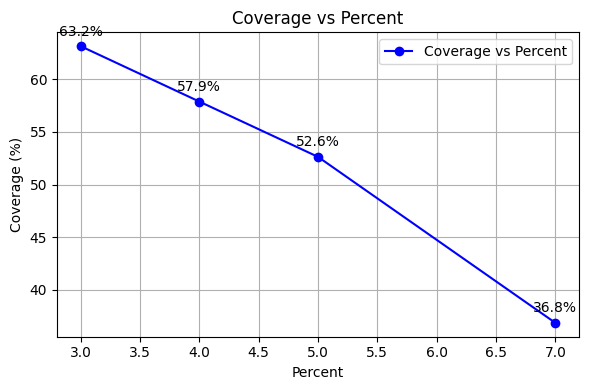

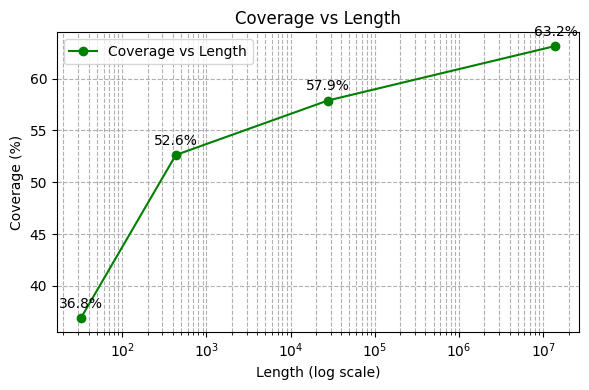

In [25]:
import matplotlib.pyplot as plt

# Данные
percent = [3, 4, 5, 7]
coverage = [63.16, 57.89, 52.63, 36.84]
length = [13996800, 27648, 432, 32]

# Создаём фигуру
plt.figure(figsize=(6,4))

# Можно отобразить coverage по percent
plt.plot(percent, coverage, 'o-', color='blue', label='Coverage vs Percent')
for x, y in zip(percent, coverage):
    plt.text(x, y+1, f"{y:.1f}%", ha='center')

plt.xlabel("Percent")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Если хочешь логарифмическую ось для length
plt.figure(figsize=(6,4))
plt.plot(length, coverage, 'o-', color='green', label='Coverage vs Length')
for x, y in zip(length, coverage):
    plt.text(x, y+1, f"{y:.1f}%", ha='center')

plt.xscale('log')  # логарифмическая ось X
plt.xlabel("Length (log scale)")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs Length")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


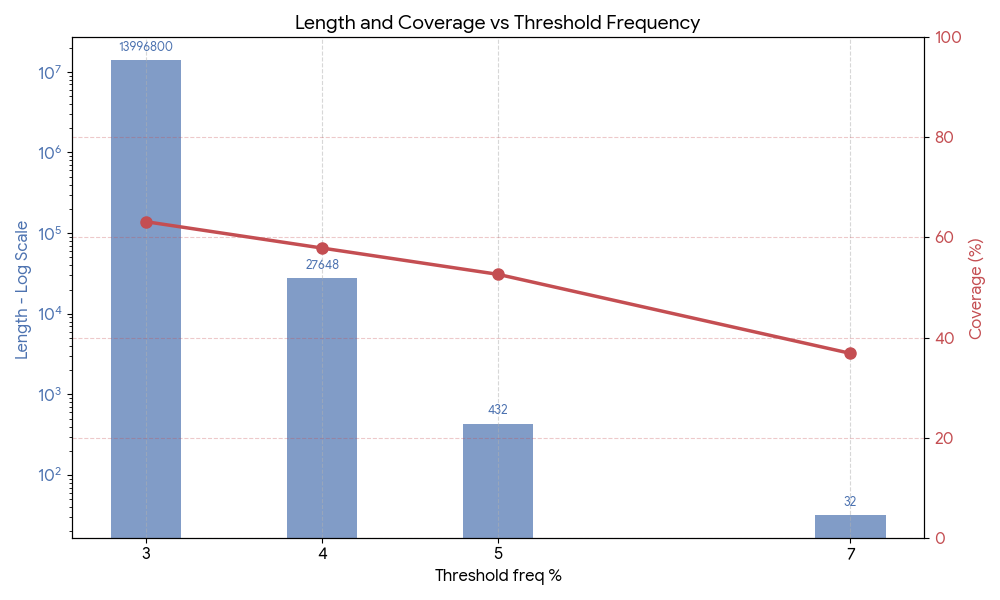

Отчётливо видно, что при увеличении количества аминокислот, которые мы используем при генерации (повышая процент при генерации), у нас увеличивается покрытие, но гораздо медленнее, чем растёт количество комбинаций (представлено в логарифмической шкале). И на практике мы не сможем проверить миллионы комбинаций прибавив процент по покрытию разнообразия. Поэтому по амиокислотной последовательности оптимальным уровнем будет 5%, достигая покрытия разнообразия в 52.63% разнообразия в базе данных